In [253]:
## Importing required libraries

import os
import datetime
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

%matplotlib inline

In [254]:
# Reading CSV file IBMStockPrice.csv
IBMStockPrice = pd.read_csv("./data/IBMStockPrice.csv", index_col="Date")
IBMStockPrice

,Open,High,Low,Close,Volume
Date,,,,,
1999-11-01,98.50,98.8100,96.370,96.75,9551800
1999-11-02,96.75,96.8100,93.690,94.81,11105400
1999-11-03,95.87,95.9400,93.500,94.37,10369100
1999-11-04,94.44,94.4400,90.000,91.56,16697600
1999-11-05,92.75,92.9400,90.190,90.25,13737600
...,...,...,...,...,...
2024-01-03,161.00,161.7300,160.080,160.10,4086065
2024-01-04,160.22,161.8100,160.170,160.86,3212004
2024-01-05,159.91,160.5500,158.670,159.16,3698961


In [255]:
# Converting Index datatype to Datetime
IBMStockPrice.index = pd.to_datetime(IBMStockPrice.index)

In [256]:
## Train-Test split for time-series
## Selecting train and test data squentially as stockPrice can't be selected at random basis
test_ratio = 0.2
training_ratio = 1 - test_ratio

train_size = int(training_ratio * len(IBMStockPrice))
test_size = int(test_ratio * len(IBMStockPrice))
print(f"train_size: {train_size}")
print(f"test_size: {test_size}")

train = IBMStockPrice[:train_size][["Close"]]
test = IBMStockPrice[train_size:][["Close"]]

train_size: 4868
test_size: 1217


<Axes: ylabel='Density'>

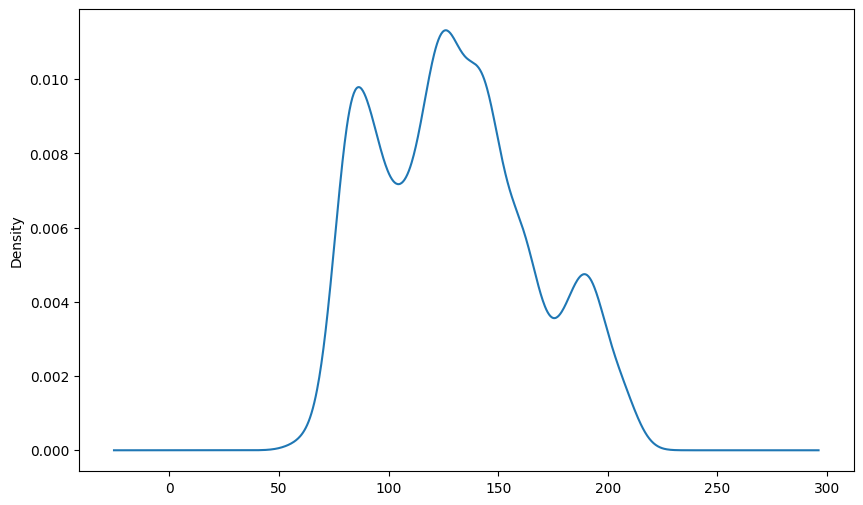

In [257]:
#Distribution of the dataset
df_close = IBMStockPrice['Close']
df_close.plot(kind='kde')

## Time Series Analysis
A time series is also regarded to include three systematic components: level, trend, and seasonality, as well as one non-systematic component termed noise.

### The Following are the componenet Analysis

1. The Average value in the series is called Level.
2. The Increasing or falling value in the series in refered to as the end of trend.
3. Seasonality is the series recurring short-term cycle
4. The random variance is the series is refered to as noise.

Because time series analysis only works with stationary data, we must determine whether the series is stationary or not.

### ADF (Augmented Dickey-Fuller) Test

One of the most widely used statistical tests is the Dickey-Fuller test. It can be used to determine whether or not a series has a unit root, and thus whether or not the series is stationary. This test’s null and alternate hypotheses are:

Null Hypothesis: The series has a unit root (value of a = 1) / Time Series is Not-stationary

Alternate Hypothesis: The series has no unit root. / The Time series is stationary

If the null hypothesis is not rejected, the series is said to be non-stationary. The series can be linear or difference stationary as a result of this.

The series becomes stationary if both the mean and standard deviation are flat lines (constant mean and constant variance).

In [258]:
adft = adfuller(df_close,autolag='AIC')
adft

(-1.7151512211460054,
 0.42332350384480727,
 25,
 6060,
 {'1%': -3.4314295498564342,
  '5%': -2.862017062668346,
  '10%': -2.5670239378764608},
 25341.960769262943)

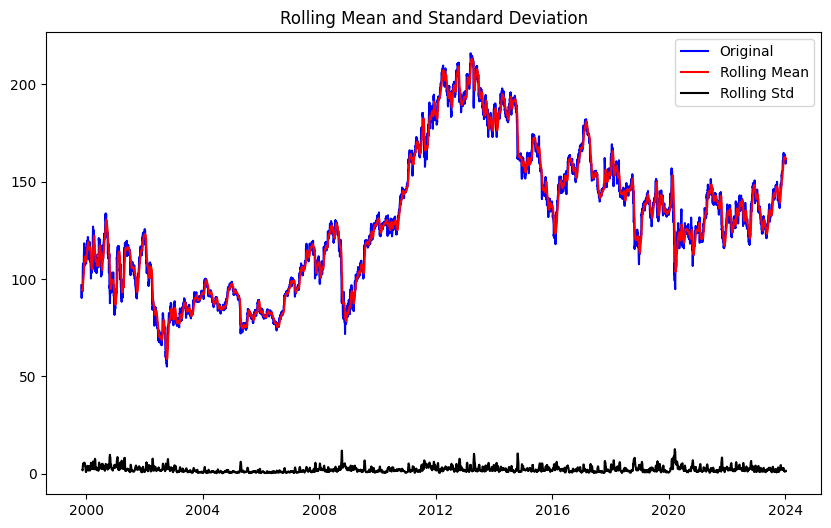

Results of dickey fuller test
ADF Test Statistics              -1.715151
p-value                           0.423324
No. of lags used                 25.000000
Number of observations used    6060.000000
critical value (1%)              -3.431430
critical value (5%)              -2.862017
critical value (10%)             -2.567024
dtype: float64


In [259]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['ADF Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

# Calling test_stationarity func with df_close
test_stationarity(df_close)

The mean and standard deviation are not constant as seen in the graph above, indicating that our series isn’t stationary.

We can’t rule out the Null hypothesis because the p-value is bigger than 0.05. Additionally, the test statistics exceed the critical values. As a result, the data is nonlinear.

Seasonality and trend may need to be separated from our series before we can undertake a time series analysis. This approach will cause the resulting series to become stagnant.

<Figure size 1000x600 with 0 Axes>

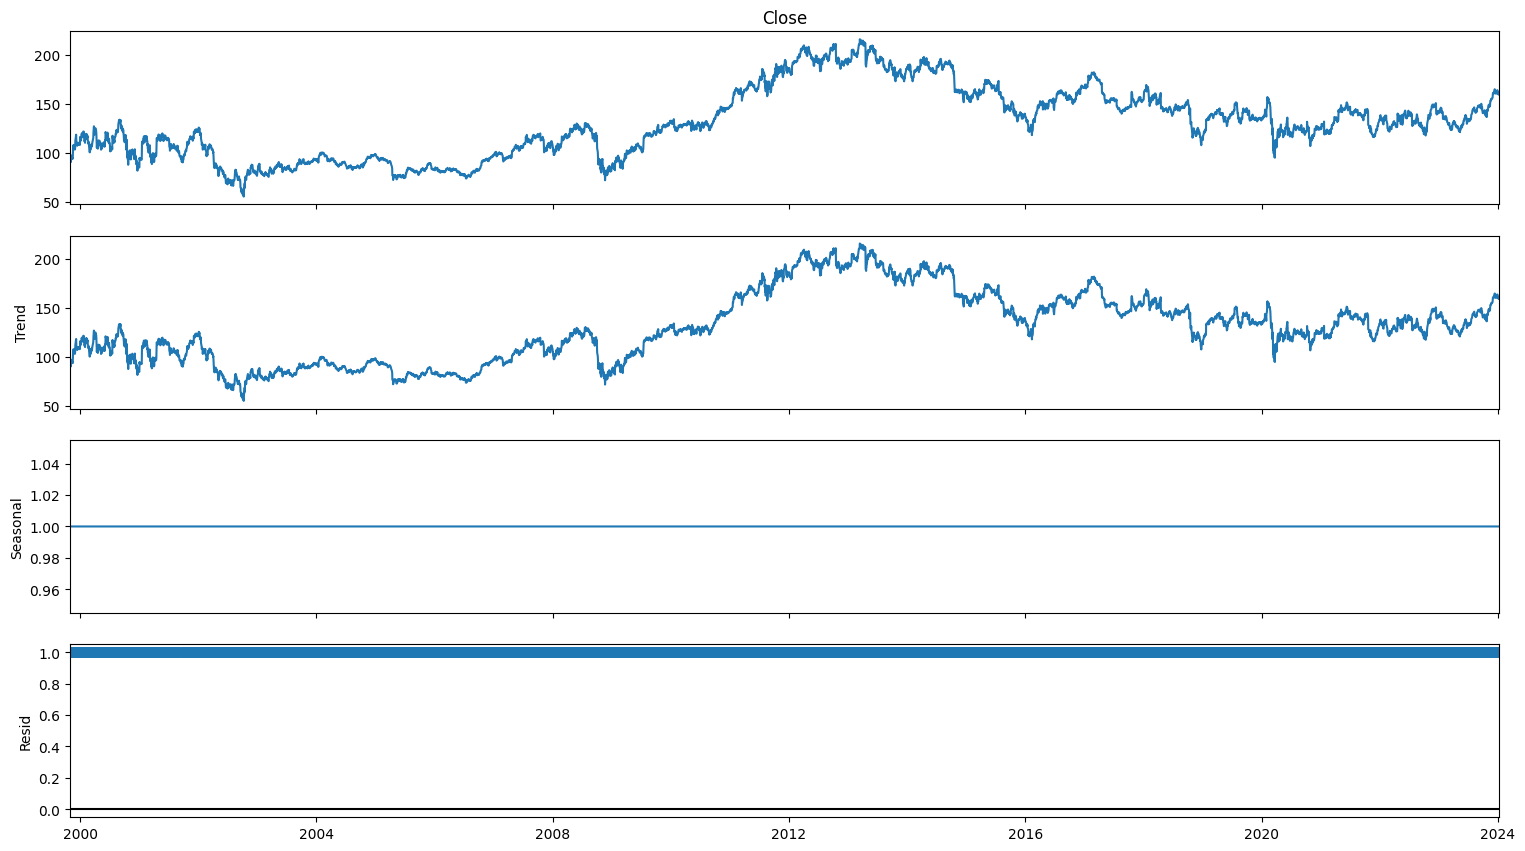

In [260]:
# Let’s isolate the time series from the Trend and Seasonality.

# To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(df_close, model='multiplicative', period=1)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

To reduce the magnitude of the values and normalize trend in the series, we first take a log of the series. We then calculate the rolling average of the series after obtaining the log of the series. A rolling average is computed by taking data from the previous 12 months and calculating a mean consumption value at each subsequent point in the series.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


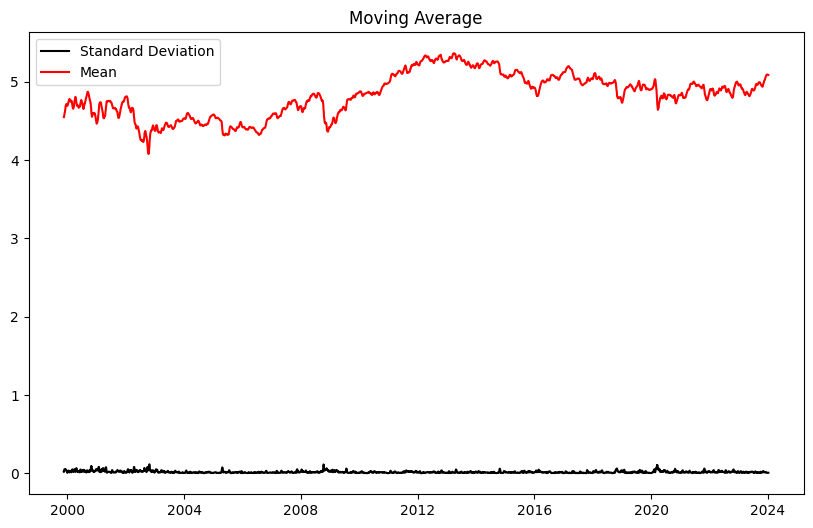

In [261]:
#if not stationary then eliminate trend
#Eliminate trend

from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

Now we’ll develop an ARIMA model and train it using the stock’s closing price from the train data. So, let’s visualize the data by dividing it into training and test sets.

As can be seen the Time series Dataset is still not stationary.

P-value is greater than 0.05 and ADF test statistics is also greater than critical value for 5% confidence interval

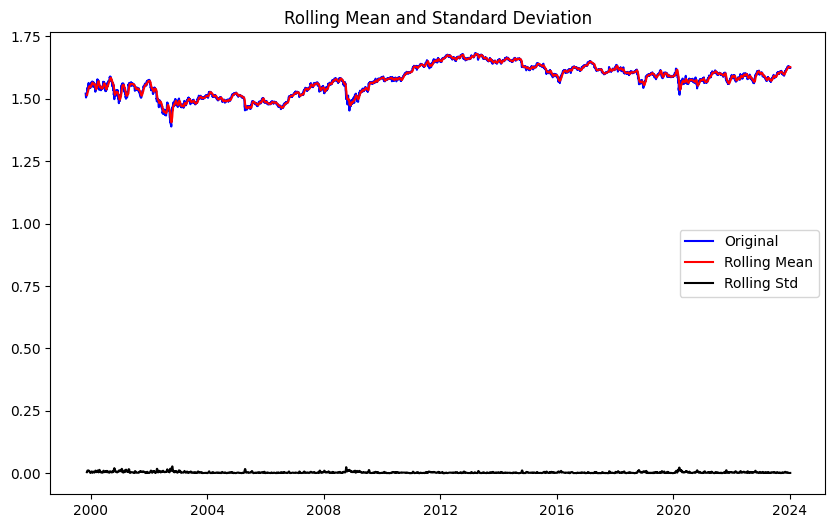

Results of dickey fuller test
ADF Test Statistics              -2.012163
p-value                           0.281266
No. of lags used                 22.000000
Number of observations used    6063.000000
critical value (1%)              -3.431429
critical value (5%)              -2.862017
critical value (10%)             -2.567024
dtype: float64


In [262]:
test_stationarity(np.log(df_log))

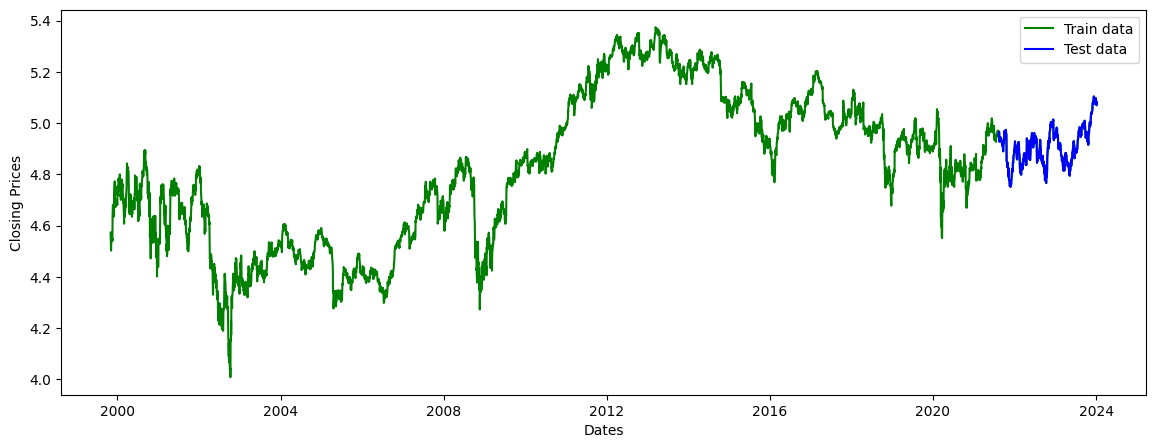

In [263]:
#split data into train and test set

train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(14,5))
# plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()
plt.show()

It’s time to choose the ARIMA model’s p,q, and d parameters and using Auto ARIMA to find the best parameters without looking at the ACF and PACF graphs.

### Auto ARIMA: Automatically discover the optimal order for an ARIMA model.

The auto_arima function returns a fitted ARIMA model after determining the most optimal parameters for an ARIMA model. This function is based on the forecast::auto. Arima R function, which is widely used.

The auro_arima function works by performing differencing tests (e.g., Kwiatkowski–Phillips–Schmidt–Shin, Augmented Dickey-Fuller, or Phillips–Perron) to determine the order of differencing, d, and then fitting models within start p, max p, start q, max q ranges. After conducting the Canova-Hansen to determine the optimal order of seasonal differencing, D, auto_arima also seeks to identify the optimal P and Q hyper-parameters if the seasonal option is enabled.

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-29204.702, Time=0.55 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-29215.238, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-29215.141, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-29206.569, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-29213.280, Time=0.54 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-29213.292, Time=0.69 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-29211.268, Time=1.43 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-29217.091, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-29215.135, Time=0.63 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-29215.146, Time=0.48 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-29216.994, Time=0.54 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-29213.123, Time=0.58 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 6.693 seconds
                               SARIMAX Results                  

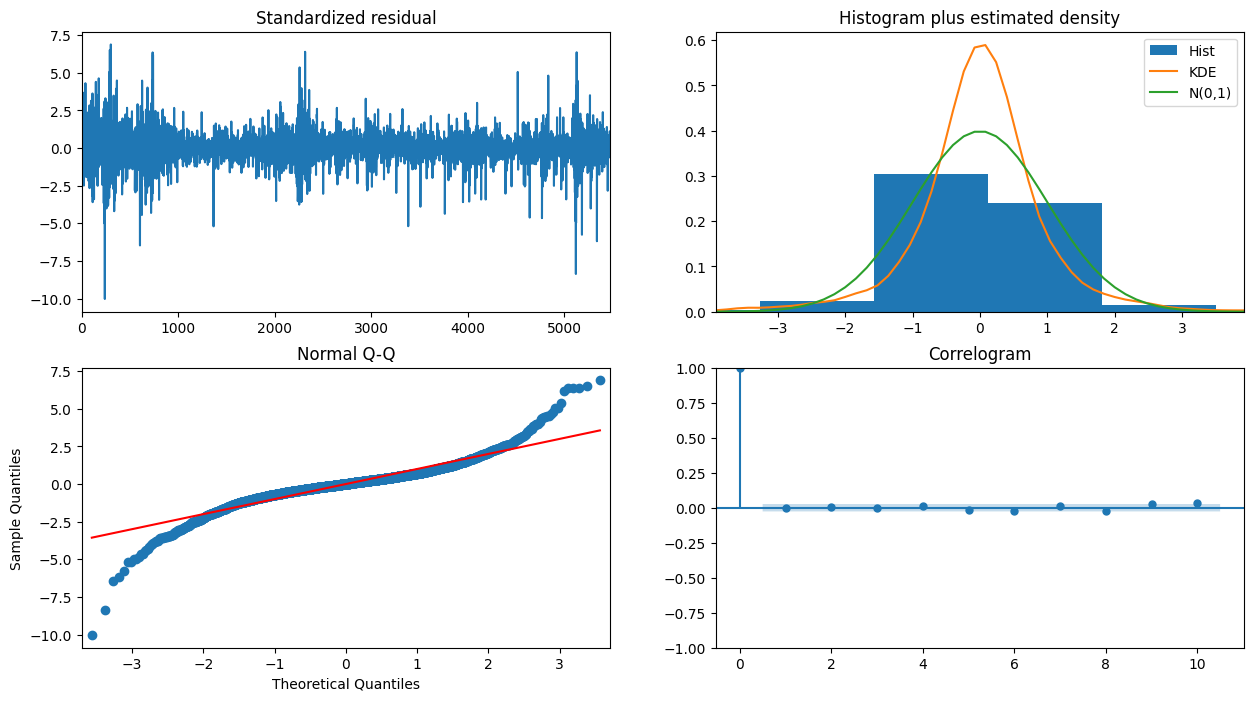

In [264]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

**Top left:** The residual errors appear to have a uniform variance and fluctuate around a mean of zero.

**Top Right:** The density plot on the top right suggests a normal distribution with a mean of zero.

**Bottom left:** The red line should be perfectly aligned with all of the dots. Any significant deviations would indicate a skewed distribution.

**Bottom Right:** The residual errors are not autocorrelated, as shown by the Correlogram, also known as the ACF plot. Any autocorrelation would imply that the residual errors have a pattern that isn’t explained by the model. As a result, you’ll need to add more Xs (predictors) to the model.

### As a result, the Auto ARIMA model assigned the values 1, 1, and 2 to, p, d, and q, respectively.

In [265]:
# Modeling
# Build Model
# Comparing ARIMA(p,d,q)(P,D,Q)[s] ---> ARIMA(1,1,0)(0,0,0)[0]

model = ARIMA(train_data, order=(1,1,0))  
fitted = model.fit()  
print(fitted.summary())


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 5474
Model:                 ARIMA(1, 1, 0)   Log Likelihood               14610.545
Date:                Thu, 18 Jan 2024   AIC                         -29217.091
Time:                        19:31:32   BIC                         -29203.876
Sample:                             0   HQIC                        -29212.480
                               - 5474                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0478      0.008     -5.626      0.000      -0.064      -0.031
sigma2         0.0003   2.37e-06    118.665      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.00   Jarque-

### Let’s now begin forecasting stock prices on the test dataset with a 95% confidence level.

Forecast Values:
5474    4.969998
5475    4.970019
5476    4.970018
5477    4.970018
5478    4.970018
          ...   
6078    4.970018
6079    4.970018
6080    4.970018
6081    4.970018
6082    4.970018
Name: predicted_mean, Length: 609, dtype: float64
      lower Close  upper Close
5474     4.937141     5.002855
5475     4.924650     5.015389
5476     4.914865     5.025172
5477     4.906574     5.033463
5478     4.899247     5.040789
...           ...          ...
6078     4.198662     5.741374
6079     4.198025     5.742012
6080     4.197388     5.742648
6081     4.196752     5.743284
6082     4.196117     5.743920

[609 rows x 2 columns]
5474    0.016764
5475    0.023148
5476    0.028140
5477    0.032370
5478    0.036108
          ...   
6078    0.393556
6079    0.393881
6080    0.394206
6081    0.394531
6082    0.394855
Name: var_pred_mean, Length: 609, dtype: float64


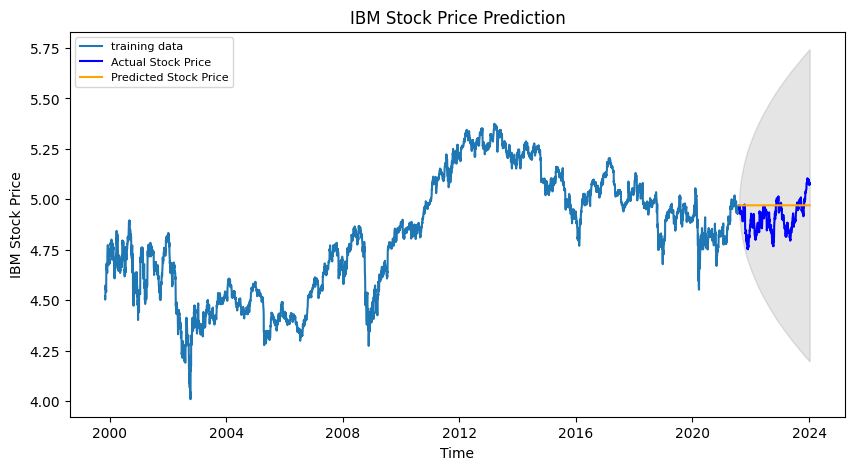

In [266]:
# Forecast
n_forecast_steps = 609
result = fitted.get_forecast(steps=n_forecast_steps)

# Assuming 'result' is the PredictionResultsWrapper object
forecast_values = result.predicted_mean

# Print the forecast values
print("Forecast Values:")
print(forecast_values)

# Extract confidence intervals
confidence_intervals = result.conf_int()
print(confidence_intervals)

# Extract standard errors
standard_errors = result.se_mean
print(standard_errors)

# Make as pandas series with Date index
new_index = test_data.index
forecast_series = pd.Series(forecast_values.values, index=new_index)
lower_series = pd.Series(confidence_intervals.values[:, 0], index=new_index)
upper_series = pd.Series(confidence_intervals.values[:, 1], index=new_index)

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(forecast_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('IBM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('IBM Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [267]:
# Model Performance Report

mse = mean_squared_error(test_data, forecast_series)
print('MSE:', mse)
mae = mean_absolute_error(test_data, forecast_series)
print('MAE:', mae)
rmse = math.sqrt(mean_squared_error(test_data, forecast_series))
print('RMSE:', rmse)
mape = np.mean(np.abs(forecast_series - test_data)/np.abs(test_data))
print('MAPE:',mape)

MSE: 0.008880969411634758
MAE: 0.07797015233665677
RMSE: 0.09423889542877059
MAPE: 0.01599822391694464


In [272]:
# Forecast future stock prices using ARIMAmodel.forecast

n_forecast_steps = 609  # Number of steps to forecast into the future / Number of days to forecast in future
future_value = fitted.forecast(steps=n_forecast_steps)

# Generate future dates for the forecasted values
future_dates = pd.date_range(start=train_data.index[-1], periods=n_forecast_steps + 1, freq='B')[1:]

futurePredictedValues = pd.Series(future_value.values, index=future_dates)

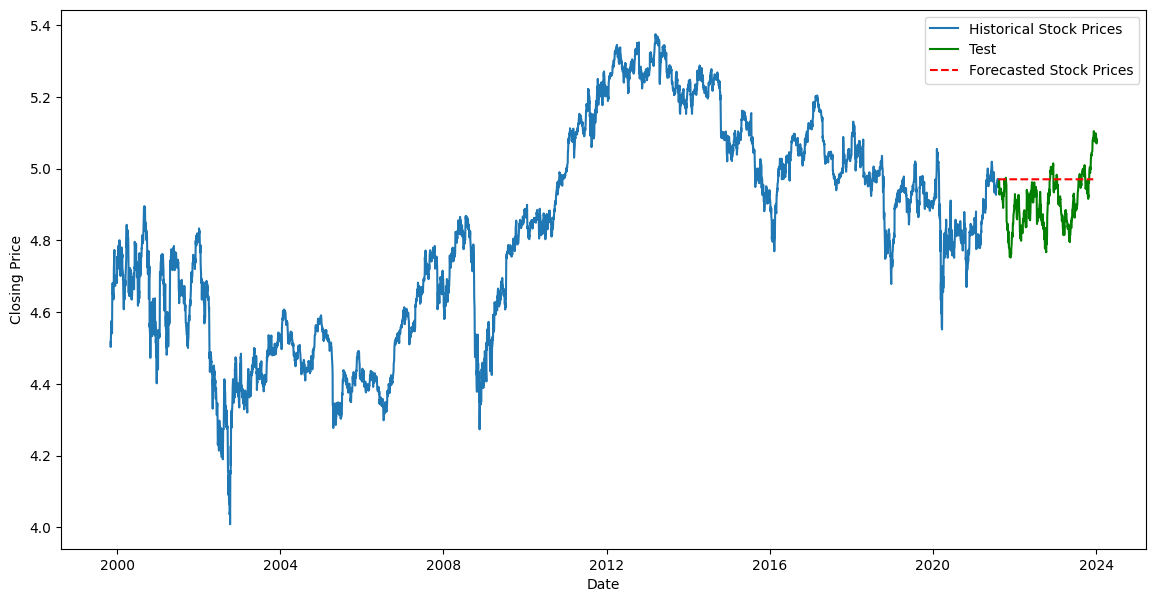

In [273]:
# prediction_index = pd.date_range(start='1999-11-04', end='2021-08-06', freq='D')
# pred_result = fitted.get_prediction(start=prediction_index[0], end=prediction_index[-1])
# predicted_values = pred_result.predicted_mean
plt.figure(figsize=(14, 7))
plt.plot(train_data, label='Historical Stock Prices')
# plt.plot(predicted_values[1:], color="red", label = "Predicted")
# plt.plot(train_data, color = "Blue", label = "Train")
plt.plot(test_data, color = "green", label="Test")
plt.plot(futurePredictedValues, color='red', linestyle='--', label='Forecasted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()